# LIBS

In [ ]:
!pip install dolphins_recognition_challenge

In [7]:
from pathlib import Path
from typing import *

import numpy as np
import shutil
from datetime import datetime
import torch
import torch.utils.data
from torch.hub import download_url_to_file
import torchvision
import PIL
from PIL import Image
from zipfile import ZipFile
import random

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from torchvision.transforms import functional as F
from torchvision.transforms import ToPILImage

from tempfile import TemporaryDirectory

from dolphins_recognition_challenge import utils

import git

import dolphins_recognition_challenge

import numpy as np
import PIL
from PIL import Image

import torch
import torchvision
import pandas as pd
import seaborn as sns
from dolphins_recognition_challenge.datasets import ToTensor, ToPILImage, Compose, RandomHorizontalFlip


print("got libz")

got libz


## NVIDIA

In [1]:
err = !nvidia-smi
if "failed" in err[0]:
    raise Exception("Change runtime in menu to GPU (Runtime->Change runtime type->GPU)")

!nvidia-smi

zsh:1: command not found: nvidia-smi


In [ ]:
try:
    import dolphins_recognition_challenge
except Exception:
    if "google.colab" in str(get_ipython()):
        print("Running on CoLab")
        !pip install dolphins-recognition-challenge


100.0%


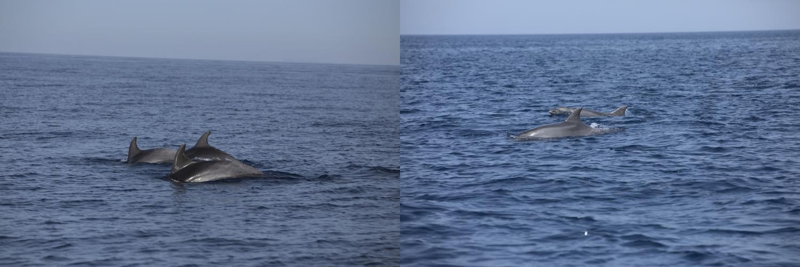

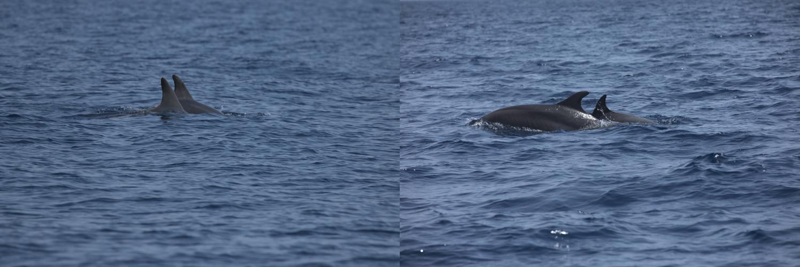

In [6]:
from dolphins_recognition_challenge.datasets import get_dataset, display_batches

data_loader, data_loader_test = get_dataset("segmentation", batch_size=2)

display_batches(data_loader, n_batches=2)


In [ ]:
def get_instance_segmentation_model(hidden_layer_size, box_score_thresh=0.5):
    # our dataset has two classes only - background and dolphin
    num_classes = 2

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=True,
        box_score_thresh=box_score_thresh,
    )

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_channels=in_features_mask,
        dim_reduced=hidden_layer_size,
        num_classes=num_classes
    )

    return model

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# get the model using our helper function
model = get_instance_segmentation_model(hidden_layer_size=256)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

from dolphins_recognition_challenge.instance_segmentation.model import train_one_epoch
from dolphins_recognition_challenge.instance_segmentation.model import show_predictions


num_epochs = 25

for epoch in range(num_epochs):
    # train for one epoch, printing every 20 iterations
    print(f"Epoch #{epoch}")

    # train for 1 epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch=epoch, print_freq=20)

    # show predictions for four images
    show_predictions(model, data_loader=data_loader_test, n=4, score_threshold=0.5)

    # update learning rate
    lr_scheduler.step()

from dolphins_recognition_challenge.instance_segmentation.model import show_prediction, iou_metric_example

for i in range(4):
    iou_test_image = iou_metric_example(model, data_loader_test.dataset[i], 0.5)
    img, _ = data_loader_test.dataset[i]
    print(f"IOU metric for the input image is: {iou_test_image}")
    show_prediction(model, img, width=820)


from dolphins_recognition_challenge.instance_segmentation.model import iou_metric, show_predictions_sorted_by_iou

mean_iou_testset, _ = iou_metric(model, data_loader_test.dataset)

print(f"Mean IOU metric for the test set is: {mean_iou_testset}")




Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /home/tin/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
13.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

32.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

61.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the c

Epoch: [0]  [ 0/40]  eta: 0:09:53  lr: 0.000133  loss: 3.4260 (3.4260)  loss_classifier: 0.7067 (0.7067)  loss_box_reg: 0.2247 (0.2247)  loss_mask: 2.4001 (2.4001)  loss_objectness: 0.0752 (0.0752)  loss_rpn_box_reg: 0.0193 (0.0193)  time: 14.8338  data: 0.6600
Epoch: [0]  [20/40]  eta: 0:05:55  lr: 0.002695  loss: 1.0054 (1.3812)  loss_classifier: 0.2284 (0.2959)  loss_box_reg: 0.2667 (0.2690)  loss_mask: 0.4817 (0.7381)  loss_objectness: 0.0237 (0.0363)  loss_rpn_box_reg: 0.0197 (0.0418)  time: 17.9394  data: 0.0062
